# Explicação
1. Carregamento do CSV e pré-processamento dos rótulos:
A função load_and_process_csv lê o arquivo com a divisão oficial e substitui os rótulos com base no dicionário MAP_CATEGORIES.

2. Criação do dataset:
A função build_dataset monta um tf.data.Dataset a partir do DataFrame, usando a coluna “filename” para compor o caminho completo da imagem e aplicando o redimensionamento (resize) com interpolação Lanczos.

3. Construção do feature extractor:
A função build_feature_extractor carrega o modelo ViT Base do HuggingFace (via TFAutoModel) e seu feature extractor (AutoFeatureExtractor). Ela constrói um modelo Keras que pré-processa as imagens (normalizando com os parâmetros do feature extractor) e, em seguida, utiliza uma camada Lambda para obter o vetor do token [CLS] (ou seja, as features fixas).

4. Extração das features:
A função extract_features itera sobre o dataset e utiliza o modelo de extração para gerar os vetores de features, concatenando-os em arrays NumPy. Junto com os rótulos, esses arrays são salvos em arquivos (.npy).



# Versão procedural

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# Defina os caminhos para os arquivos de features e labels
OUTPUT_DIR = os.path.join("..", "./output", "/content/drive/My Drive/Mestrado 2024/Projetos/Datasets/vit_features_gastroVision/facebook_deit-base-distilled-patch16-224")
TRAIN_FEATURES_PATH = os.path.join(OUTPUT_DIR, "train_features.npy")
TRAIN_LABELS_PATH   = os.path.join(OUTPUT_DIR, "train_labels.npy")
VALIDATION_FEATURES_PATH = os.path.join(OUTPUT_DIR, "validation_features.npy")
VALIDATION_LABELS_PATH   = os.path.join(OUTPUT_DIR, "validation_labels.npy")
TEST_FEATURES_PATH  = os.path.join(OUTPUT_DIR, "test_features.npy")
TEST_LABELS_PATH    = os.path.join(OUTPUT_DIR, "test_labels.npy")

# Carrega os arrays NumPy
train_features = np.load(TRAIN_FEATURES_PATH)
train_labels   = np.load(TRAIN_LABELS_PATH)
val_features   = np.load(VALIDATION_FEATURES_PATH)
val_labels     = np.load(VALIDATION_LABELS_PATH)
test_features  = np.load(TEST_FEATURES_PATH)
test_labels    = np.load(TEST_LABELS_PATH)

print("Shape das features de treino:", train_features.shape)
print("Shape dos rótulos de treino:", train_labels.shape)
print("Shape das features de validação:", val_features.shape)
print("Shape dos rótulos de validação:", val_labels.shape)
print("Shape das features de teste:", test_features.shape)
print("Shape dos rótulos de teste:", test_labels.shape)

# Normalização das features (média zero e variância unitária) com base no conjunto de treino
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Define o classificador SVM com kernel RBF e pesos balanceados
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Define os parâmetros para busca em grid (valores de C e gamma)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# Usa GridSearchCV com validação cruzada para selecionar o melhor hiperparâmetro
grid_search = GridSearchCV(
    svm,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)
grid_search.fit(train_features, train_labels)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliação no conjunto de validação usando o melhor modelo
best_svm = grid_search.best_estimator_
val_predictions = best_svm.predict(val_features)

# Métricas no conjunto de validação
val_accuracy = accuracy_score(val_labels, val_predictions)
val_f1_macro = f1_score(val_labels, val_predictions, average='macro')

print("Acurácia no conjunto de validação:", val_accuracy)
print("F1 Macro no conjunto de validação:", val_f1_macro)

# Faz predições no conjunto de teste usando o melhor modelo
#test_predictions = best_svm.predict(test_features)

# Calcula métricas no conjunto de teste
#test_accuracy = accuracy_score(test_labels, test_predictions)
#test_f1_macro = f1_score(test_labels, test_predictions, average='macro')

#print("Acurácia no conjunto de teste:", test_accuracy)
#print("F1 Macro no conjunto de teste:", test_f1_macro)

# Gera o relatório de classificação detalhado para o conjunto de teste
#report = classification_report(test_labels, test_predictions, output_dict=True)
report = classification_report(test_labels, test_predictions, output_dict=True)

df_report = pd.DataFrame(report).transpose()
print("\nRelatório de Classificação:\n", df_report)

# Salva o relatório de classificação em um arquivo CSV
output_report_path = './output/classification_report.csv'
os.makedirs(os.path.dirname(output_report_path), exist_ok=True)  # Cria o diretório se não existir
df_report.to_csv(output_report_path, index=True)
print(f"Relatório salvo em: {output_report_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Mestrado 2024/Projetos/Datasets/vit_features_gastroVision/facebook_deit-base-distilled-patch16-224/train_labels.npy'

In [ ]:
from google.colab import files
!zip -r facebook_deit-base-distilled-patch16-224 ./output
files.download('./facebook_deit-base-distilled-patch16-224.zip')

  adding: output/ (stored 0%)
  adding: output/classification_report.csv (deflated 65%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Versão 1.0

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

class SVMClassifier:
    def __init__(self, data_dir, output_dir="./output", cv_folds=5):
        """
        Classe para treinar um SVM, realizar validação cruzada e extrair métricas detalhadas.

        Parâmetros:
        - data_dir (str): Caminho da pasta contendo os arquivos de features e labels.
        - output_dir (str): Caminho onde os resultados serão salvos.
        - cv_folds (int): Número de folds para validação cruzada (padrão: 5).
        """
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.cv_folds = cv_folds
        self.best_model = None
        self.metrics_per_fold = []  # Armazena métricas médias (macro avg)
        self.f1_scores_per_fold = []  # Apenas F1-score para teste estatístico
        self.class_report_list = []  # Armazena os relatórios por classe

        os.makedirs(self.output_dir, exist_ok=True)

    def load_data(self):
        """Carrega os arquivos de features e labels."""
        train_features_path = os.path.join(self.data_dir, "train_features.npy")
        train_labels_path = os.path.join(self.data_dir, "train_labels.npy")

        self.train_features = np.load(train_features_path)
        self.train_labels = np.load(train_labels_path)

        print("📥 Dados carregados com sucesso!")
        print(f"Shape das features de treino: {self.train_features.shape}")
        print(f"Shape dos rótulos de treino: {self.train_labels.shape}")

    def preprocess_data(self):
        """Normaliza as features usando StandardScaler."""
        self.scaler = StandardScaler()
        self.train_features = self.scaler.fit_transform(self.train_features)
        print("🔄 Dados normalizados!")

    def train_svm(self):
        """Treina o modelo SVM com `GridSearchCV` e extrai métricas detalhadas por classe e fold."""
        print("🚀 Iniciando treinamento do SVM...")

        # Modelo SVM com kernel RBF
        svm = SVC(kernel='rbf', class_weight='balanced', probability=True)

        # Parâmetros para Grid Search
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }

        # Configuração do GridSearchCV
        grid_search = GridSearchCV(
            svm,
            param_grid,
            scoring='f1_macro',
            cv=self.cv_folds,
            n_jobs=-1,
            verbose=2,
            return_train_score=True
        )

        # Treinar modelo com validação cruzada
        grid_search.fit(self.train_features, self.train_labels)
        self.best_model = grid_search.best_estimator_

        print("\n🏆 Melhores parâmetros encontrados:", grid_search.best_params_)

        # 🎯 **Usando o melhor modelo para validação cruzada novamente**
        skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        y_pred = cross_val_predict(self.best_model, self.train_features, self.train_labels, cv=skf)

        # 🎯 **Gerar relatório de métricas por fold**
        report = classification_report(self.train_labels, y_pred, output_dict=True, zero_division=0)

        # 📊 Criando DataFrame para armazenar os resultados por classe
        df_class_report = pd.DataFrame(report).transpose()
        class_report_path = os.path.join(self.output_dir, "classification_report_per_class.csv")
        df_class_report.to_csv(class_report_path, index=True)

        print("\n📊 Relatório detalhado por classe salvo em:", class_report_path)
        print(df_class_report)

        for i in range(self.cv_folds):
            precision = report["macro avg"]["precision"]
            recall = report["macro avg"]["recall"]
            f1_score = report["macro avg"]["f1-score"]
            support = sum(report[label]["support"] for label in report if label not in ["accuracy", "macro avg", "weighted avg"])

            self.metrics_per_fold.append({
                "Fold": i + 1,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1_score,
                "Support": support
            })
            self.f1_scores_per_fold.append(f1_score)

        # 🎯 **Salvar métricas médias em CSV**
        df_metrics = pd.DataFrame(self.metrics_per_fold)
        metrics_path = os.path.join(self.output_dir, "metrics_per_fold.csv")
        df_metrics.to_csv(metrics_path, index=False)

        print("\n📊 Métricas médias por fold salvas em:", metrics_path)
        print(df_metrics)

    def get_f1_scores(self):
        """Retorna os F1-scores por fold para uso em testes estatísticos."""
        return self.f1_scores_per_fold



In [ ]:


# ------------------------------
# Exemplo de uso da classe
# ------------------------------
if __name__ == "__main__":
    DATA_DIR = "/content/drive/My Drive/Mestrado 2024/Projetos/Datasets/vit_features_gastroVision/facebook_vit-mae-base"

    classifier = SVMClassifier(DATA_DIR)
    classifier.load_data()
    classifier.preprocess_data()
    classifier.train_svm()

    # Obtendo apenas os F1-scores para teste estatístico
    f1_scores = classifier.get_f1_scores()
    print("\n📈 F1-scores prontos para testes estatísticos:", f1_scores)

📥 Dados carregados com sucesso!
Shape das features de treino: (3722, 768)
Shape dos rótulos de treino: (3722,)
🔄 Dados normalizados!
🚀 Iniciando treinamento do SVM...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🏆 Melhores parâmetros encontrados: {'C': 10, 'gamma': 'auto'}

📊 Relatório detalhado por classe salvo em: ./output/classification_report_per_class.csv
              precision    recall  f1-score      support
0              0.696133  0.692308  0.694215   182.000000
1              0.677083  0.726257  0.700809   179.000000
2              0.720524  0.789474  0.753425   209.000000
3              0.765550  0.812183  0.788177   197.000000
4              0.552083  0.654321  0.598870   162.000000
5              0.683544  0.687898  0.685714   157.000000
6              0.625000  0.629139  0.627063   151.000000
7              0.714286  0.660377  0.686275   159.000000
8              0.652482  0.643357  0.647887   143.000000
9              0.659722  0.673759  0.666667   141

In [ ]:
from google.colab import files
!zip -r facebook_vit-mae-base ./output
files.download('./facebook_vit-mae-base.zip')

  adding: output/ (stored 0%)
  adding: output/classification_report_per_class.csv (deflated 57%)
  adding: output/.ipynb_checkpoints/ (stored 0%)
  adding: output/metrics_per_fold.csv (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Versão 2.0

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve
import joblib


class SVMClassifier:
    def __init__(self, data_dir, output_dir="./output", cv_folds=5, extrator_name=None,use_gridsearch=True, C=None, gamma=None):

        """
        Inicializa a classe SVMClassifier.

        Args:
            data_dir (str): Diretório contendo os dados.
            output_dir (str): Diretório para salvar os resultados.
            cv_folds (int): Número de folds para validação cruzada.
            use_gridsearch (bool): Se True, usa GridSearch para encontrar os melhores parâmetros.
                                   Se False, usa os valores de C e gamma fornecidos.
            C (float): Valor de C para o SVM (usado apenas se use_gridsearch=False).
            gamma (float): Valor de gamma para o SVM (usado apenas se use_gridsearch=False).
        """
        self.data_dir = data_dir
        self.extrator_name =  extrator_name
        self.output_dir = output_dir
        self.cv_folds = cv_folds
        self.use_gridsearch = use_gridsearch
        self.C = C
        self.gamma = gamma
        self.best_model = None
        self.best_model = None
        self.metrics_per_fold = []
        self.f1_scores_per_fold = []
        self.class_report_list = []
        os.makedirs(self.output_dir, exist_ok=True)

    def load_data(self):
        train_features_path = os.path.join(self.data_dir, "train_features.npy")
        train_labels_path = os.path.join(self.data_dir, "train_labels.npy")
        val_features_path = os.path.join(self.data_dir, "validation_features.npy")
        val_labels_path = os.path.join(self.data_dir, "validation_labels.npy")
        test_features_path = os.path.join(self.data_dir, "test_features.npy")
        test_labels_path = os.path.join(self.data_dir, "test_labels.npy")

        self.train_features = np.load(train_features_path)
        self.train_labels = np.load(train_labels_path)
        self.val_features = np.load(val_features_path)
        self.val_labels = np.load(val_labels_path)
        self.test_features = np.load(test_features_path)
        self.test_labels = np.load(test_labels_path)

        print("📥 Dados carregados com sucesso!")
        print(f"Shape das features de treino: {self.train_features.shape}")
        print(f"Shape dos rótulos de treino: {self.train_labels.shape}")
        print(f"Shape das features de validação: {self.val_features.shape}")
        print(f"Shape dos rótulos de validação: {self.val_labels.shape}")
        print(f"Shape das features de teste: {self.test_features.shape}")
        print(f"Shape dos rótulos de teste: {self.test_labels.shape}")

    def preprocess_data(self):
         # Reshape the feature data to 2D
        #self.train_features = self.train_features.reshape(self.train_features.shape[0], -1)
        #self.val_features = self.val_features.reshape(self.val_features.shape[0], -1)
        #self.test_features = self.test_features.reshape(self.test_features.shape[0], -1)

        self.scaler = RobustScaler()
        self.train_features = self.scaler.fit_transform(self.train_features)
        self.val_features = self.scaler.transform(self.val_features)
        self.test_features = self.scaler.transform(self.test_features)
        print("🔄 Dados normalizados!")


    def plot_learning_curve(self):
        '''
          curva de aprendizado
        '''
        train_sizes, train_scores, val_scores = learning_curve(
            self.best_model, self.train_features, self.train_labels, cv=self.cv_folds, scoring='f1_macro'
        )
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Treino")
        plt.plot(train_sizes, np.mean(val_scores, axis=1), label="Validação")
        plt.title("Curva de Aprendizado")
        plt.xlabel("Tamanho do Conjunto de Treino")
        plt.ylabel("F1-score")
        plt.legend()
        plt.show()

    def check_class_balance(self):
        '''
          análise de balanceamento de classes
        '''
        #print("📊 Distribuição das classes no treino:", Counter(self.train_labels))
        #print("📊 Distribuição das classes na validação:", Counter(self.val_labels))

        # Criando um DataFrame
        train_distribution = Counter(self.train_labels)
        val_distribution = Counter(self.val_labels)
        df = pd.DataFrame({
            "Classe": list(train_distribution.keys()),
            "Quantidade no Treino": list(train_distribution.values()),
            "Quantidade na Validação": [val_distribution[cls] for cls in train_distribution.keys()]
        })

        # Ordenando o DataFrame pela coluna "Classe"
        df = df.sort_values(by="Classe").reset_index(drop=True)
        # Exibindo a tabela
        print("\n📊 Tabela de Distribuição das Classes")
        print(df)



    def plot_confusion_matrix(self):
        '''
        matriz de confusão
        '''
        y_pred = self.best_model.predict(self.val_features)
        cm = confusion_matrix(self.val_labels, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Matriz de Confusão {self.extrator_name}")
        plt.show()


    def plot_pca(self):
        '''
            visualização com PCA
        '''
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(self.train_features)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.train_labels, cmap='viridis')
        plt.title(f"Visualização das características com PCA {self.extrator_name}")
        plt.show()

    def train_svm(self):
        print("🚀 Iniciando treinamento do SVM...")

        if self.use_gridsearch:
            svm = SVC(kernel='rbf',probability=True) #class_weight='balanced',
            param_grid = {
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 'scale', 'auto']
                }

            grid_search = GridSearchCV(
                svm,
                param_grid,
                scoring='f1_macro',
                cv=self.cv_folds,
                n_jobs=-1,
                verbose=2,
                return_train_score=True
            )

            grid_search.fit(self.train_features, self.train_labels)
            self.best_model = grid_search.best_estimator_
            print("🏆 Melhores parâmetros encontrados:", grid_search.best_params_)
        else:
             print("🔧 Usando parâmetros pré-definidos...")

             if self.C is None or self.gamma is None:
                raise ValueError("Os valores de C e gamma devem ser fornecidos se use_gridsearch=False.")

             self.best_model = SVC(
                                  kernel='rbf',

                                  probability=True,
                                  C=self.C,
                                  gamma=self.gamma
                                ) #class_weight='balanced',
             self.best_model.fit(self.train_features, self.train_labels)
             print(f"✅ Modelo treinado com C={self.C} e gamma={self.gamma}")


        # 🎯 **Usando o melhor modelo para validação cruzada novamente**

        skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        y_pred = cross_val_predict(self.best_model, self.val_features, self.val_labels, cv=skf)

        report = classification_report(self.val_labels, y_pred, output_dict=True, zero_division=0)
        df_class_report = pd.DataFrame(report).transpose()
        class_report_path = os.path.join(self.output_dir, "classification_report_per_class.csv")
        df_class_report.to_csv(class_report_path, index=True)

        print("📊 Relatório detalhado por classe salvo em:", class_report_path)
        print(df_class_report)

        # variáveis para metricas por fold
        self.metrics_per_fold = []
        self.f1_scores_per_fold = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(self.val_features, self.val_labels)):
            X_train_fold, X_val_fold = self.val_features[train_idx], self.val_features[val_idx]
            y_train_fold, y_val_fold = self.val_labels[train_idx], self.val_labels[val_idx]

            # Treinar o modelo no fold atual
            self.best_model.fit(X_train_fold, y_train_fold)
            # Fazer previsões no fold de validação
            y_pred_fold = self.best_model.predict(X_val_fold)

            # Calcular métricas para o fold atual
            precision = precision_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
            recall = recall_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
            f1 = f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
            support = len(y_val_fold)

            # Armazenar métricas
            self.metrics_per_fold.append({
              "Fold": fold + 1,
              "Precision": precision,
              "Recall": recall,
              "F1-score": f1,
              "Support": support
           })
            self.f1_scores_per_fold.append(f1)

        # Salvar métricas em um DataFrame
        df_metrics = pd.DataFrame(self.metrics_per_fold)
        metrics_path = os.path.join(self.output_dir, "metrics_per_fold.csv")
        df_metrics.to_csv(metrics_path, index=False)

        print("📊 Métricas médias por fold salvas em:", metrics_path)
        print(df_metrics)

    def get_f1_scores(self):
        """Retorna os F1-scores por fold para uso em testes estatísticos."""
        return self.f1_scores_per_fold

    def merge_dataset(self):
          self.train_features = np.vstack((self.train_features, self.val_features))
          self.train_labels = np.hstack((self.train_labels, self.val_labels))
          print("Shape das features de treino após união:", self.train_features.shape)
          print("Shape dos rótulos de treino após união:", self.train_labels.shape)

    def retrain_best_model(self):
        """Retreina o modelo com os dados de treino e validação combinados."""
        print("🔄 Unindo conjunto de treino e validação...")
        self.merge_dataset()

        print("🚀 Treinando modelo final com dados combinados...")
        self.best_model.fit(self.train_features, self.train_labels)
        print("✅ Modelo final treinado!")

        # Salvar o modelo final
        model_path = os.path.join(self.output_dir, "final_svm_model.pkl")
        joblib.dump(self.best_model, model_path)
        print(f"💾 Modelo final salvo em: {model_path}")

    def evaluate_on_test(self):
        """Avalia o modelo no conjunto de teste."""
        print("🧪 Avaliando o modelo no conjunto de teste...")
        y_pred = self.best_model.predict(self.test_features)

        # Relatório de classificação
        report = classification_report(self.test_labels, y_pred, output_dict=True, zero_division=0)
        df_class_report = pd.DataFrame(report).transpose()
        test_report_path = os.path.join(self.output_dir, "test_classification_report.csv")
        df_class_report.to_csv(test_report_path, index=True)

        print("📊 Relatório de classificação no teste salvo em:", test_report_path)
        print(df_class_report)

        # Matriz de confusão
        cm = confusion_matrix(self.test_labels, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Matriz de Confusão no Teste - {self.extrator_name}")
        plt.xlabel("Previsto")
        plt.ylabel("Real")
        plt.show()


## Testando

In [ ]:


# ------------------------------
# Uso da classe
# ------------------------------
if __name__ == "__main__":
    extrator_name = "facebook_vit-mae-large"
    DATA_DIR = f"/content/drive/My Drive/Mestrado 2024/Projetos/Datasets/vit_features_gastroVision/{extrator_name}"

    classifier = SVMClassifier(DATA_DIR, extrator_name=extrator_name,use_gridsearch=False,C=10,gamma=0.0001) # convex-net: 🏆 Melhores parâmetros encontrados: {'C': 1, 'gamma': 0.01}; vit: C=10,gamma=0.0001

    classifier.load_data()
    classifier.preprocess_data()

📥 Dados carregados com sucesso!
Shape das features de treino: (3722, 1024)
Shape dos rótulos de treino: (3722,)
Shape das features de validação: (793, 1024)
Shape dos rótulos de validação: (793,)
Shape das features de teste: (803, 1024)
Shape dos rótulos de teste: (803,)
🔄 Dados normalizados!


In [ ]:
# Avaliação dos dados

classifier.check_class_balance()



📊 Tabela de Distribuição das Classes
    Classe  Quantidade no Treino  Quantidade na Validação
0        0                   182                       45
1        1                   179                       39
2        2                   209                       44
3        3                   197                       45
4        4                   162                       38
5        5                   157                       37
6        6                   151                       27
7        7                   159                       31
8        8                   143                       30
9        9                   141                       24
10      10                   152                       29
11      11                   151                       35
12      12                   133                       27
13      13                   121                       24
14      14                   152                       39
15      15                   188  

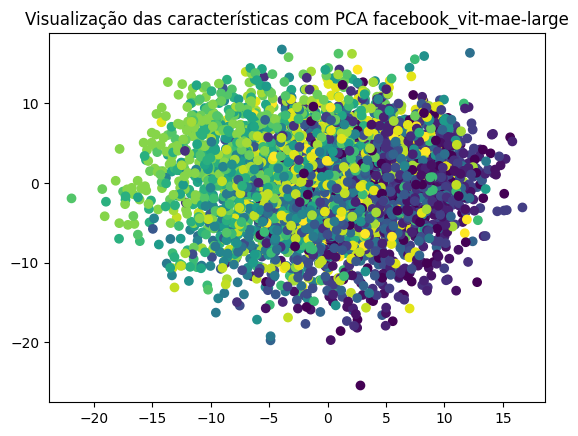

In [ ]:
classifier.plot_pca()

In [ ]:

# Treinar modelo

classifier.train_svm()
#classifier.plot_learning_curve() # apresenta curva de aprendizado
#classifier.plot_confusion_matrix() # apresenta matrix de confusão

 # Obtendo apenas os F1-scores para teste estatístico
f1_scores = classifier.get_f1_scores()
print("\n📈 F1-scores prontos para testes estatísticos:", f1_scores)

🚀 Iniciando treinamento do SVM...
🔧 Usando parâmetros pré-definidos...
✅ Modelo treinado com C=10 e gamma=0.0001
📊 Relatório detalhado por classe salvo em: ./output/classification_report_per_class.csv
              precision    recall  f1-score     support
0              0.611111  0.733333  0.666667   45.000000
1              0.625000  0.641026  0.632911   39.000000
2              0.761905  0.727273  0.744186   44.000000
3              0.636364  0.777778  0.700000   45.000000
4              0.567568  0.552632  0.560000   38.000000
5              0.541667  0.702703  0.611765   37.000000
6              0.500000  0.370370  0.425532   27.000000
7              0.656250  0.677419  0.666667   31.000000
8              0.750000  0.500000  0.600000   30.000000
9              0.576923  0.625000  0.600000   24.000000
10             0.565217  0.448276  0.500000   29.000000
11             0.724138  0.600000  0.656250   35.000000
12             0.571429  0.444444  0.500000   27.000000
13             

In [ ]:
# Obtendo apenas os F1-scores para teste estatístico
f1_scores = classifier.get_f1_scores()
print("\n📈 F1-scores prontos para testes estatísticos:", f1_scores)


📈 F1-scores prontos para testes estatísticos: [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792]


#### Retreino com Dados Combinados:



In [ ]:
classifier.retrain_best_model()

# Obtendo apenas os F1-scores para teste estatístico
f1_scores = classifier.get_f1_scores()
print("\n📈 F1-scores prontos para testes estatísticos:", f1_scores)

🔄 Unindo conjunto de treino e validação...
Shape das features de treino após união: (4515, 1024)
Shape dos rótulos de treino após união: (4515,)
🚀 Treinando modelo final com dados combinados...
✅ Modelo final treinado!
💾 Modelo final salvo em: ./output/final_svm_model.pkl

📈 F1-scores prontos para testes estatísticos: [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792]


In [ ]:
classifier.check_class_balance()


📊 Tabela de Distribuição das Classes
    Classe  Quantidade no Treino  Quantidade na Validação
0        0                   227                       45
1        1                   218                       39
2        2                   253                       44
3        3                   242                       45
4        4                   200                       38
5        5                   194                       37
6        6                   178                       27
7        7                   190                       31
8        8                   173                       30
9        9                   165                       24
10      10                   181                       29
11      11                   186                       35
12      12                   160                       27
13      13                   145                       24
14      14                   191                       39
15      15                   231  

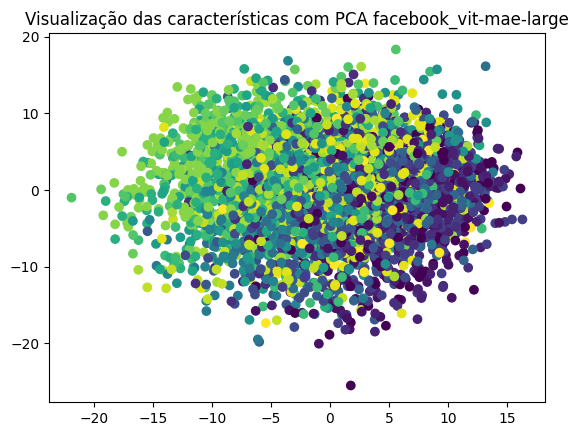

In [ ]:
classifier.plot_pca()

#### Retreino com Dados Combinados:



🧪 Avaliando o modelo no conjunto de teste...
📊 Relatório de classificação no teste salvo em: ./output/test_classification_report.csv
              precision    recall  f1-score     support
0              0.723404  0.790698  0.755556   43.000000
1              0.823529  0.800000  0.811594   35.000000
2              0.803571  0.882353  0.841121   51.000000
3              0.800000  0.782609  0.791209   46.000000
4              0.571429  0.645161  0.606061   31.000000
5              0.722222  0.742857  0.732394   35.000000
6              0.589744  0.766667  0.666667   30.000000
7              0.617647  0.700000  0.656250   30.000000
8              0.720000  0.666667  0.692308   27.000000
9              0.722222  0.764706  0.742857   34.000000
10             0.846154  0.594595  0.698413   37.000000
11             0.821429  0.657143  0.730159   35.000000
12             0.789474  0.500000  0.612245   30.000000
13             0.696970  0.821429  0.754098   28.000000
14             0.684211  0.

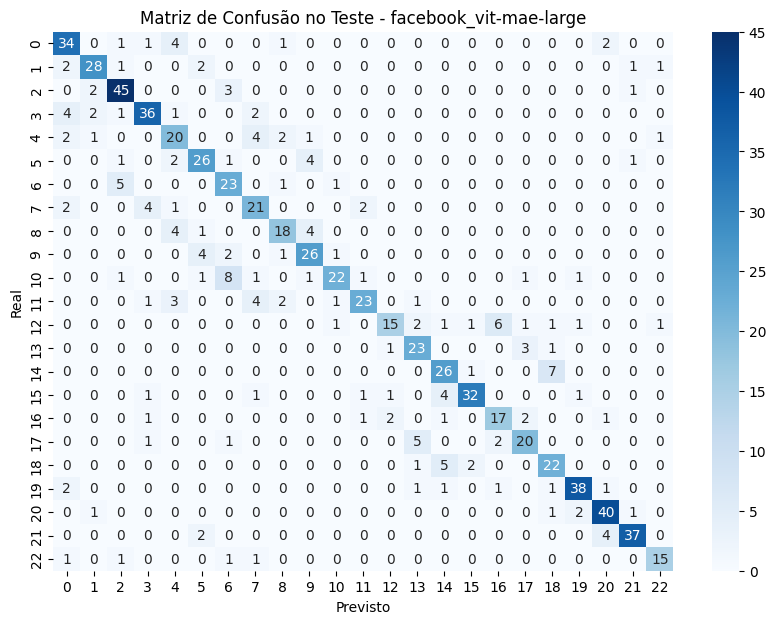

In [ ]:
classifier.evaluate_on_test()


## Baixar arquivo

In [ ]:
from google.colab import files
!zip -r {extrator_name}.zip ./output
files.download(f'./{extrator_name}.zip')

  adding: output/ (stored 0%)
  adding: output/test_classification_report.csv (deflated 64%)
  adding: output/metrics_per_fold.csv (deflated 41%)
  adding: output/classification_report_per_class.csv (deflated 62%)
  adding: output/final_svm_model.pkl (deflated 58%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>